In [1]:
# TORCHIFYING BATCHNORM FOR MAKEMORE

In [215]:
import torch
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [216]:
# build dataset

block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [217]:
# split into splits

import random
random.seed(21476891001)
random.shuffle(words)

g = torch.Generator().manual_seed(21476891001)

n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [254]:
# Create a linear class to initialize a layer, return embeddings(__call__), return return embeddings(from constructor)

class Linear():
    def __init__(self, fan_in, fan_out, bias=True):
        self.w = torch.randn((fan_in, fan_out), generator=g) #/ fan_in ** 0.5
        self.b = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x): 
        self.out = x @ self.w
        if self.b is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        return [self.w] + ([] if self.b is None else [self.b])

In [255]:
# create batch normalization class for a 2d or 3d input 
class BatchNorm1d:
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True 
        
        # parameters trained with back propagation
        self.gamma = torch.ones(num_features) 
        self.beta = torch.zeros(num_features)
        
        # running parameters updated with running momentum
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)
        
        
    # calcualte forward pass, update buffers, return layer
    def __call__(self, x):
        # calculate forward pass
        if self.training:
            xmean = x.mean(0, keepdims=True)
            xvar = x.var(0, keepdims=True, correction=1) 
        else: 
            xmean = self.running_mean
            xvar = self.running_var
        
        # normalize each neuron
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        # scale and shift
        self.out = self.gamma * (xhat) + self.beta
        
        # update buffers
        # momentum use - smooths out the mean, var(how? takes fraction of running mean and current mean)
        ### can be used to avoid jitter when training
        if self.training: 
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    # return parameters
    def parameters(self):
        return [self.gamma, self.beta]

In [256]:
class Tanh():
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [264]:
# MLP implementation
n_embd = 10 # dimensionality of character embedding
n_hidden = 100 # number of neurons in hidden layer

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear((n_embd * block_size), n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden),  Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden),  Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#     Linear((n_embd * block_size), n_hidden), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
#     Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden),Tanh(),
#     Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
# ]
# layers = [
#     Linear((n_embd * block_size), n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden),Tanh(),
#     Linear(n_hidden, n_hidden),Tanh(),
#     Linear(n_hidden, vocab_size),
# ]

with torch.no_grad():
    # make last layer less confident
    layers[-1].gamma *= 0.1
    
    # calcualte the gain for other layers
    for l in layers[:-1]:
        if isinstance(l, Linear):
            l.w *= 5/3
    
parameters = [C] + [p for l in layers for p in l.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True # require for backprop

47024


In [270]:
# optimization

max_steps = 2000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # train with a mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    
    # forward pass
    for layer in layers:
        x = layer(x)
        
    # loss
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    # return grad for layers
    for l in layers:
        l.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += p.grad * -lr
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    lossi.append(loss.item())
    break


      0/   2000: 3.314887


layer 2 (      Tanh): mean +0.00, std 0.61, saturated: 4.34%
layer 5 (      Tanh): mean +0.00, std 0.62, saturated: 3.66%
layer 8 (      Tanh): mean -0.01, std 0.63, saturated: 3.41%
layer 11 (      Tanh): mean -0.01, std 0.62, saturated: 3.84%
layer 14 (      Tanh): mean +0.00, std 0.62, saturated: 3.88%


Text(0.5, 1.0, 'activation distribution')

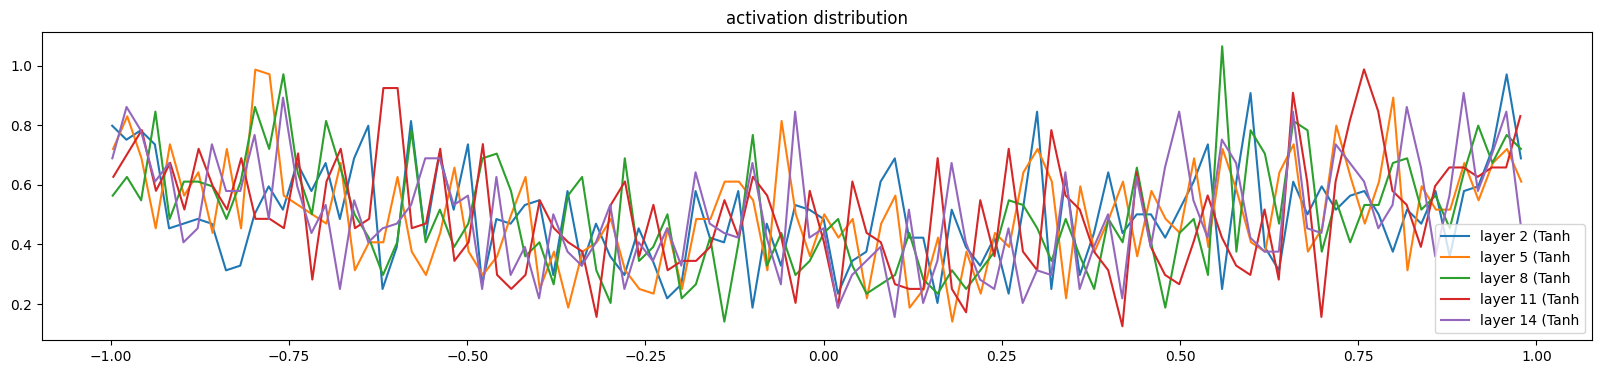

In [271]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer(softmax)
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 1.496964e-03
layer 5 (      Tanh): mean +0.000000, std 1.116201e-03
layer 8 (      Tanh): mean +0.000000, std 8.342381e-04
layer 11 (      Tanh): mean +0.000000, std 6.647431e-04
layer 14 (      Tanh): mean +0.000000, std 5.248853e-04


Text(0.5, 1.0, 'gradient distribution')

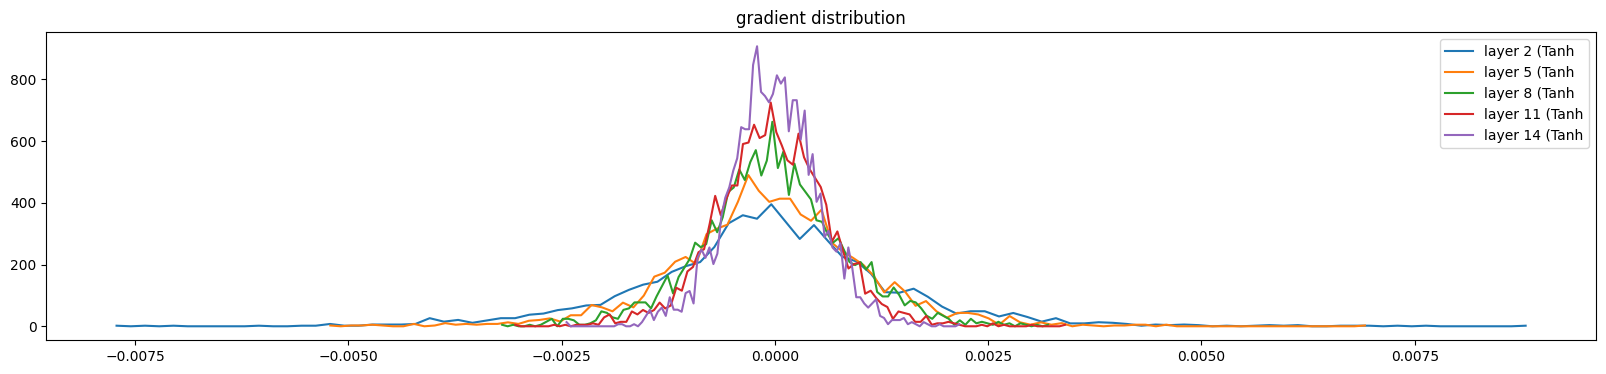

In [272]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 2.291833e-03 | grad:data ratio 2.221619e-03
weight  (30, 100) | mean -0.000043 | std 2.646547e-03 | grad:data ratio 8.704250e-03
weight (100, 100) | mean +0.000017 | std 2.252799e-03 | grad:data ratio 1.350814e-02
weight (100, 100) | mean -0.000009 | std 1.801386e-03 | grad:data ratio 1.092983e-02
weight (100, 100) | mean +0.000012 | std 1.526760e-03 | grad:data ratio 9.215604e-03
weight (100, 100) | mean -0.000004 | std 1.304162e-03 | grad:data ratio 7.865800e-03
weight  (100, 27) | mean +0.000012 | std 2.027316e-03 | grad:data ratio 1.201209e-02


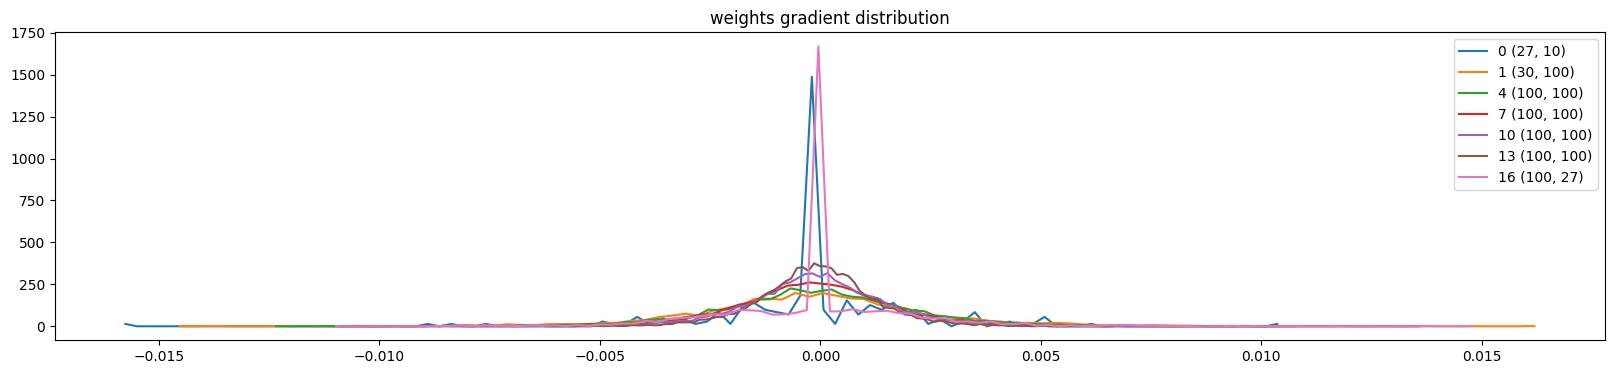

In [273]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

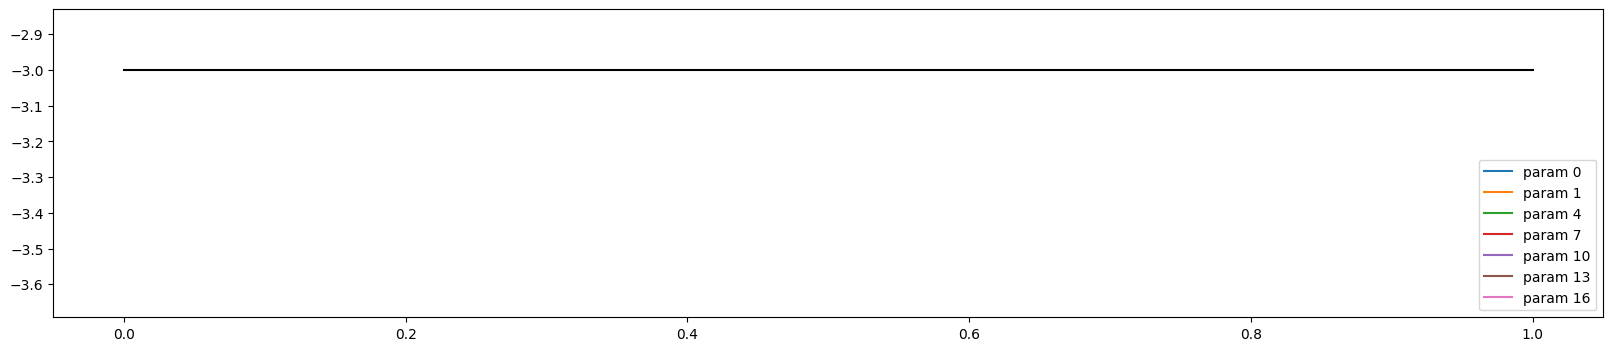

In [274]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [275]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 3.2952566146850586
val 3.294813871383667


In [54]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carlah.
amelle.
khi.
mili.
taty.
salaysa.
jazhetn.
den.
art.
kaqui.
ner.
kiah.
maiiv.
kaleigh.
ham.
join.
quint.
shoilea.
jadbi.
wazelon.
